In [0]:
# If you run this notebook on Google Colaboratory, uncomment the below to install automl_alex.
#!pip install automl-alex

In [1]:
import pandas as pd
import numpy as np
import sklearn
import automl_alex
import json
from automl_alex import BestSingleModelClassifier

In [2]:
print(automl_alex.__version__)

0.07.17


In [3]:
RANDOM_SEED = 42

# Classifier

## Data

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
dataset = fetch_openml(name='credit-g', version=1, as_frame=True)
dataset.target = dataset.target.astype('category').cat.codes
dataset.data.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


In [5]:
X_train, X_test, y_train, y_test = train_test_split(dataset.data, 
                                                    dataset.target,
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED,)
X_train.shape, X_test.shape

((800, 20), (200, 20))

## Model

In [6]:
model = BestSingleModelClassifier(X_train, y_train, X_test, random_state=RANDOM_SEED)

Source X_train shape:  (800, 20) | X_test shape:  (200, 20)
Auto detect cat features:  13
> Start preprocessing Data
> Generate cat encodet features
 +  55  Features from  OneHotEncoder
 +  44  Features from  HelmertEncoder
 +  54  Features from  HashingEncoder
 +  16  Features from  FrequencyEncoder
> Clean Nans in num features
> Generate interaction Num Features
 +  24 Interaction Features
##################################################
> Total Generated Features:  185
New X_train shape:  (800, 201) | X_test shape:  (200, 201)
##################################################


In [7]:
history = model.opt(timeout=1000, verbose=1)

One iteration takes ~ 0.8 sec
Start Auto calibration parameters
Start optimization with the parameters:
CV_Folds =  10
Score_CV_Folds =  5
Opt_lvl =  3
Cold_start =  80.0
Early_stoping =  160.0
Metric =  roc_auc_score
Direction =  maximize
Default model OptScore = 0.6256
########################################
Optimize: : 624it [15:18,  1.44s/it,  | Model: LinearModel | OptScore: 0.7454 | Best roc_auc_score: 0.7621 +- 0.016687]
 EarlyStopping Exceeded: Best Score: 0.7454 roc_auc_score
Optimize: : 624it [15:18,  1.47s/it,  | Model: LinearModel | OptScore: 0.7454 | Best roc_auc_score: 0.7621 +- 0.016687]


In [8]:
model.history_trials_dataframe.head(5)

,score_opt,model_score,score_std,model_name,model_param,wrapper_params,cat_encoders,columns,cv_folds
462,0.7454,0.7621,0.016687,LinearModel,"{'verbose': 0, 'fit_intercept': False, 'C': 95...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","[num_dependents, OneHotEncoder_personal_status...",10
582,0.7449,0.7675,0.022554,LinearModel,"{'verbose': 0, 'fit_intercept': False, 'C': 47...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","[num_dependents, OneHotEncoder_personal_status...",10
607,0.7445,0.7666,0.022069,LinearModel,"{'verbose': 0, 'fit_intercept': False, 'C': 30...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","[num_dependents, OneHotEncoder_personal_status...",10
568,0.7445,0.7667,0.022182,LinearModel,"{'verbose': 0, 'fit_intercept': False, 'C': 46...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","[num_dependents, OneHotEncoder_personal_status...",10
545,0.7440,0.7658,0.021751,LinearModel,"{'verbose': 0, 'fit_intercept': False, 'C': 91...",{},"[OneHotEncoder, HelmertEncoder, HashingEncoder...","[num_dependents, OneHotEncoder_personal_status...",10


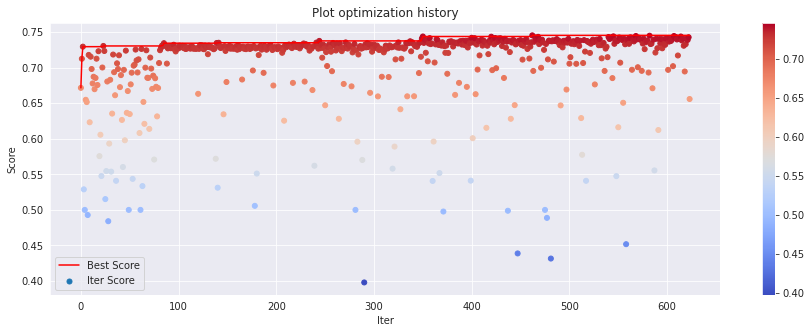

In [9]:
model.plot_opt_history()

In [10]:
predicts = model.predict()
print('Test AUC: ', round(sklearn.metrics.roc_auc_score(y_test, predicts['predict_test'][0]),4))

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
 Mean Score roc_auc_score on 30 Folds: 0.7757 std: 0.057386
Test AUC:  0.8107

